# Expedia Hotel Recommendation

Data Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

# 1. Data preprocessing & EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import missingno as msno
import ml_metrics as metrics

### 1-0. Load Dataset

In [2]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

### 1-1. Check Dataset

In [3]:
# print('train.shape :', train.shape)
# print('test.shape :', test.shape)
# print('destinations.shape', destinations.shape)

# # check destinationmissing values
# print(destinations.tail())
# print(train.tail())
# print(train.info())
# print(test.tail())
# print(test.info())
# train.describe()
# test.describe()
# print(len(train.columns), train.columns)
# print(len(test.columns), test.columns)

- destination.csv
    - row index와 srch_destination_id가 차이나는 것으로 보아, missing된 id가 존재하는 것으로 판단 (대략 5% 미만) -> 어떻게 처리할지? : 비율이 적어 삭제해도 무방할 듯
- train.csv
    - 대부분 integer, float variable
    - date time는 년,월,일,시 등으로 format 변경 필요
    - user_loaction_country, user_location_city value의 정확한 의미 알 수 없어 사용이 어려워 보임 (keep)
    - orig_destination_distance Nan 어떻게 처리할지? --> data description에 의하면 Nan value는 계산이 불가능한 경우 :
        - A null means the distance could not be calculated

- train set 너무 많음(3700만 개) --> 이대로 계속 분석 가능한지?(메모리 이슈) : sampling

In [4]:
test_user = set(test.user_id.unique())
train_user = set(train.user_id.unique())
print(test_user in train_user)

False


- Train set에 포함되지 않은 유저가 Test set에 존재

### 1-2. Check missing values in data 

In [5]:
def check_nan(df):
    for col in df.columns:
        msg = '{:>10}\t\t\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df[col].isnull().sum() / df[col].shape[0]))
        print(msg)

In [6]:
# print(check_nan(train))
# print(check_nan(test))

- Train.csv column
    - ID 없음
- test.csv column
    - missing value 없음
    - is_booking, cnt, hotel_cluster(label) column 없음

In [7]:
def check_nan_col(df, col_list):
    for cl in col_list:
        Nan_idx = list(df.loc[df[cl].isnull()][cl].index)
        print('Nan of', cl, ': ', len(Nan_idx))

In [8]:
# train에만 결측치 있음
print(check_nan_col(train, ['srch_ci', 'srch_co']))

Nan of srch_ci :  47083
Nan of srch_co :  47084
None


- Checkin data와 Checkout data의 누락이 대부분 겹치치만, 각각 누락된 것도 있음
- data description에 의하면 알 수 없는 컬럼이며, 전체 데이터 비율에 비해 매우 작은 비율을 차지하므로 삭제

In [9]:
# delete srch_ci, srch_co nan row 
def delete_nan_col(df, col_list):
    df.dropna(subset=col_list, axis=0, inplace=True)

In [10]:
delete_nan_col(train, ['srch_ci', 'srch_co'])
print(check_nan_col(train, ['srch_ci', 'srch_co']))

Nan of srch_ci :  0
Nan of srch_co :  0
None


- Train set의 srch_ci, srch_co 결측치 삭제 완료

In [11]:
# msno.bar(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.bar(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### 1-3. Delete checkin/checkout error rows

In [12]:
io_error_idx = train[train['srch_ci'] > train['srch_co']].index
train.drop(index=io_error_idx, inplace=True)

### 1-4. Check label data distribution

min: 48275 max: 1042545


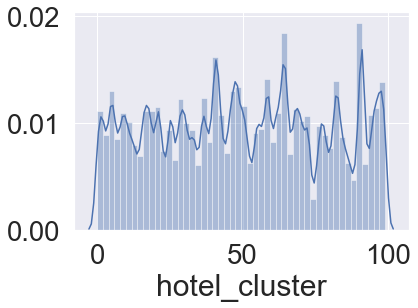

In [13]:
train['hotel_cluster'].value_counts()
sns.distplot(train['hotel_cluster'])
print('min:',min(train['hotel_cluster'].value_counts()), 'max:',max(train['hotel_cluster'].value_counts()))

### 1-5. Convert Dates to Year & Month for original Train/Test set

In [14]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
# print(train.head())

In [15]:
test['date_time'] = pd.to_datetime(test['date_time'])
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
# print(test.head())

### 1-6. Remove not booking user data

In [16]:
# userid_isbooking_group = train.groupby(['user_id'])['is_booking'].value_counts()
isbooking_user_group = train.groupby(['is_booking'])['user_id'].value_counts()

booking_user_list = train[train.is_booking == 1].user_id.tolist() # user_id idx list that book at least once
# print(real_user_list)

In [17]:
train_booking = train.loc[booking_user_list, :]
# train.info()

### 1-6. Downsizing dataset (by User random sampling) not for train_booking

In [18]:
# train_userid_group = train.groupby(['user_id'])['hotel_cluster'].value_counts()

# print('[train] unique user count :',train['user_id'].nunique())
# print('[test] unique user count :',test['user_id'].nunique())

- 1,198,786 user -> 100,000 user random sampling (Considering computation resource)

In [19]:
# sampling_size = 100000

In [20]:
# def random_sampling(df, key_col, sampling_size, origin_file, chunk_size):
#     unique_set = set(df[key_col].unique())
#     sampling_set = random.sample(unique_set, sampling_size)

#     df_sampling = pd.DataFrame()
#     df_chunking = pd.read_csv(origin_file, chunksize = chunk_size) 

#     for c in df_chunking:
#         df_sampling = df_sampling.append(c.loc[c[key_col].isin(sampling_set)])
        
#     return df_sampling

In [21]:
# train_sampling = random_sampling(df=train, key_col='user_id', sampling_size=sampling_size, origin_file='train.csv', chunk_size=100000)
# print('sampling unique user count :',train_sampling['user_id'].nunique())    

In [22]:
# train_origin = pd.DataFrame.copy(train)

In [23]:
train_booking['date_time'] = pd.to_datetime(train_booking['date_time'])
train_booking['year'] = train_booking['date_time'].dt.year
train_booking['month'] = train_booking['date_time'].dt.month
train_booking['day'] = train_booking['date_time'].dt.day
# train_sampling.head()

In [24]:
# train_origin['date_time'] = pd.to_datetime(train_origin['date_time'])
# train_origin['year'] = train_origin['date_time'].dt.year
# train_origin['month'] = train_origin['date_time'].dt.month
# train_origin['day'] = train_origin['date_time'].dt.day
# # train_origin.head()

In [25]:
# train_sampling['date_time'] = pd.to_datetime(train_sampling['date_time'])
# train_sampling['year'] = train_sampling['date_time'].dt.year
# train_sampling['month'] = train_sampling['date_time'].dt.month
# train_sampling['day'] = train_sampling['date_time'].dt.day

In [26]:
# delete srch_ci, srch_co nan row in train_sampling
# train_sampling.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [27]:
# train_origin.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [28]:
train_booking.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [29]:
# orig_destination_distance 
# print(train_sampling['orig_destination_distance'].median(skipna=True))
# print(train_sampling['orig_destination_distance'].mean(skipna=True))
# train_sampling['orig_destination_distance'].describe()
# train_sampling.groupby(['user_id'])['orig_destination_distance'].describe()

In [30]:
# hotel_distance = train_sampling.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
# print(hotel_distance)

- orig_destination_distance
    - 거리개념이라 음수또는 0으로 처리하기엔 좋지 않음
    - 전체 mean, median을 일괄적용하기에는 Nan 비율이 너무 높음
    - 각 유저별 mean 또는 median을 고려하기엔 user_id별 로그가 전혀없는 것들이 있음
    - Hotel_cluster별 mean을 적용해보자

In [34]:
train_booking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2997341 entries, 12 to 1198182
Data columns (total 27 columns):
date_time                    datetime64[ns]
site_name                    float64
posa_continent               float64
user_location_country        float64
user_location_region         float64
user_location_city           float64
orig_destination_distance    float64
user_id                      float64
is_mobile                    float64
is_package                   float64
channel                      float64
srch_ci                      object
srch_co                      object
srch_adults_cnt              float64
srch_children_cnt            float64
srch_rm_cnt                  float64
srch_destination_id          float64
srch_destination_type_id     float64
is_booking                   float64
cnt                          float64
hotel_continent              float64
hotel_country                float64
hotel_market                 float64
hotel_cluster                f

In [35]:
def fill_distance_by_cluster(df): # can use this func if the df has the 'hotel_cluster' column
    hotel_distance = df.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
    cluster_avg_distance = pd.DataFrame(hotel_distance['mean'].tolist(), columns=['avg_distance'])
    cluster_avg_distance['hotel_cluster'] = pd.DataFrame(cluster_avg_distance.index.tolist())

    df = pd.merge(df, cluster_avg_distance, how='inner', on='hotel_cluster', left_index=True)
    df.orig_destination_distance.fillna(df['avg_distance'], inplace=True)
    df = df.drop("avg_distance", axis=1)
    
    return df

In [36]:
# train_sampling = fill_distance_by_cluster(train_sampling)

In [37]:
# train_origin = fill_distance_by_cluster(train_origin)

In [38]:
train_booking = fill_distance_by_cluster(train_booking)

In [39]:
# train_sampling.info()

In [40]:
# train_sampling.groupby(['year'])['month'].value_counts()
# train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()
# train_sampling.groupby(['hotel_cluster'])['user_id'].value_counts()
# print(min(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))
# print(max(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))
# train_sampling.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()

In [31]:
# print(min(train_sampling.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))
# print(max(train_sampling.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))

1
25669


In [41]:
print(min(train_booking.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))
print(max(train_booking.groupby(['srch_destination_id'])['hotel_cluster'].value_counts()))

1
22040


In [42]:
check_nan(train_booking)

 date_time			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Percent of NaN value: 0.00%
is_package			 Percent of NaN value: 0.00%
   channel			 Percent of NaN value: 0.00%
   srch_ci			 Percent of NaN value: 0.00%
   srch_co			 Percent of NaN value: 0.00%
srch_adults_cnt			 Percent of NaN value: 0.00%
srch_children_cnt			 Percent of NaN value: 0.00%
srch_rm_cnt			 Percent of NaN value: 0.00%
srch_destination_id			 Percent of NaN value: 0.00%
srch_destination_type_id			 Percent of NaN value: 0.00%
is_booking			 Percent of NaN value: 0.00%
       cnt			 Percent of NaN value: 0.00%
hotel_continent			 Percent of NaN value: 0.00%
hotel_country			 Percent of N

In [44]:
# check_nan(train_origin)

### 1-6. Feature correlation analysis

In [45]:
# train.corr()[train.corr() > 0.5] # run just once 

In [46]:
# train.corr()['hotel_cluster']

In [47]:
# most missing feature : orig_destination_distance 
# Physical distance between a hotel and a customer at the time of search. 
# A null means the distance could not be calculated
# train.corr()['orig_destination_distance']

In [48]:
# train.corr()['srch_destination_id']

- data description에 의해 직관적으로 중요해보이는 column에 대한 correlation 분석 실시
- hotel_cluster와 선형 상관관계가 있는 feature는 없으므로, linear regression은 적합하지 않다고 판단
- ML model을 돌리기 위한 추가 피처 고려 필요 (destination.csv)

### 1-7. Additional feature generation with PCA

In [49]:
# destinations.isnull().sum()
# destinations.tail() 

- srch_destination_id에 결측치 있음

In [50]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=149)
destination_full_components = pca_full.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.95) + 1
print('dim over 95% :', dim)

pca = PCA(n_components=dim)
destination_compression = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(dim)]])
destination_compression = pd.DataFrame(destination_compression)
destination_compression["srch_destination_id"] = destinations["srch_destination_id"]
# print('eigen_value :', pca.explained_variance_)
# print('explained variance ratio :', pca.explained_variance_ratio_)

dim over 95% : 59


- 누적된 분산의 비율이 95%가 되도록 차원 결정

In [51]:
# destination_compression.tail()
# destination_compression.isnull().sum()

### 1-8. Generate new feature

- date_time 관련 time property에 대한 피처 추가
- srch_in, srch_out 관련 date property에 대한 피처 추가
- train_sampling feature와 destinations pca 결과 feature를 concat
- train_sampling data set으로 학습

In [53]:
def merge_features(df): 
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    new_features = {}
    
    # Add time feature of date_time
    kind_of_time = ["quarter", "month", "dayofweek", "day", "hour", "minute"]
    for t in kind_of_time:
        new_features[t] = getattr(df["date_time"].dt, t)
    
    # Add date feature of srch_ci, srch_co & 
    kind_of_date = ["month", "day", "dayofweek", "quarter"]
    for d in kind_of_date:
        new_features["ci_{0}".format(d)] = getattr(df["srch_ci"].dt, d)
        new_features["co_{0}".format(d)] = getattr(df["srch_co"].dt, d)
    new_features["duration_of_stay"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    
    # Add others feature
    column_others = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for c in column_others:
        new_features[c] = df[c]
    
    new_features_df = pd.DataFrame(new_features)
    
    # Concat destinations features
    new_features_df = new_features_df.join(destination_compression, 
                                           on="srch_destination_id", 
                                           how='left', 
                                           rsuffix="destination_compression")
    new_features_df = new_features_df.drop("srch_destination_iddestination_compression", axis=1)

    return new_features_df

In [54]:
train_booking_addition = merge_features(train_booking)

In [57]:
# train_sampling_addition = merge_features(train_sampling)
# train_sampling_addition

In [58]:
# train_origin_addition = merge_features(train_origin)
# train_origin_addition

In [59]:
# train_sampling_addition.tail()
# train_sampling_addition.describe()

In [60]:
# check_nan(train_sampling_addition)

In [61]:
check_nan(train_booking_addition)

   quarter			 Percent of NaN value: 0.00%
     month			 Percent of NaN value: 0.00%
 dayofweek			 Percent of NaN value: 0.00%
       day			 Percent of NaN value: 0.00%
      hour			 Percent of NaN value: 0.00%
    minute			 Percent of NaN value: 0.00%
  ci_month			 Percent of NaN value: 0.00%
  co_month			 Percent of NaN value: 0.00%
    ci_day			 Percent of NaN value: 0.00%
    co_day			 Percent of NaN value: 0.00%
ci_dayofweek			 Percent of NaN value: 0.00%
co_dayofweek			 Percent of NaN value: 0.00%
ci_quarter			 Percent of NaN value: 0.00%
co_quarter			 Percent of NaN value: 0.00%
duration_of_stay			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Perc

- missing values : 샘플링할 때마다 차이가 생김. missing value candidate은 아래와 같다
    - ci_dayofweek
    - co_dayofweek
    - ci_quarter
    - co_quarter
    - duration_of_stay
    - srch_destination_id & 0-58

In [58]:
# check_nan(train_origin_addition)

### 1-9. srch_destination_id missing value 전략
- feature 간의 상관관계가 없고, 전체 dataset 중에서 missing value가 차지하는 비율이 매우 적음
- missing value를 처리하는 여러 방법 중, 제거하는 방법을 선택

In [59]:
train_sampling_addition.dropna(inplace=True)

In [63]:
# train_origin_addition.dropna(inplace=True)

In [60]:
for col in train_sampling_addition.columns:
    print(col, train_sampling_addition[col].isnull().sum())

quarter 0
month 0
dayofweek 0
day 0
hour 0
minute 0
ci_month 0
co_month 0
ci_day 0
co_day 0
ci_dayofweek 0
co_dayofweek 0
ci_quarter 0
co_quarter 0
duration_of_stay 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 0
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0


In [61]:
# for col in train_origin_addition.columns:
#     print(col, train_origin_addition[col].isnull().sum())

In [62]:
# train_sampling_addition.describe()

# 2. Hotel cluster classification

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


## 2-0. Data preparation (recap)

### Train / Test split by train_sampling (ratio 80:20)
- month 기준으로 분할 (일 기준으로 나눌 수 있지만, 분석의 용이성을 높이고자)
- 24 month data를 8:2로 나누면, 대략 19 : 5 

In [91]:
train_new = train_sampling_addition[((train_sampling_addition.year == 2013) | ((train_sampling_addition.year == 2014) & (train_sampling_addition.month <= 7)))]
test_new = train_sampling_addition[((train_sampling_addition.year == 2014) & (train_sampling_addition.month >= 8))]
test_new = test_new[test_new.is_booking == 1]
test_new

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
60,3,8,1,19,8,12,8,8,22,23,...,-0.002614,0.005141,-0.000049,0.002156,-0.005777,0.004707,-0.004103,-0.000945,0.001189,-0.000399
60,3,8,3,21,9,11,8,9,31,4,...,0.001058,0.002349,0.002636,-0.004965,-0.002395,-0.000871,-0.003291,0.010262,-0.001704,0.000396
60,3,8,4,15,17,39,8,8,21,23,...,0.000928,0.000237,-0.001249,0.001359,0.000712,-0.000771,0.000569,-0.000075,-0.000644,-0.000038
60,3,8,1,5,12,30,8,8,15,17,...,0.001833,-0.002440,0.003780,-0.001019,0.001424,0.001924,-0.001179,0.001810,0.000913,0.001024
60,4,11,2,12,15,43,12,12,5,8,...,-0.000694,0.000663,0.000367,0.004844,-0.002389,0.000897,-0.000576,-0.001718,-0.000916,0.000220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,4,11,1,11,22,27,11,11,27,30,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,12,2,17,14,31,12,12,26,27,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,10,6,26,23,23,1,1,22,26,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121
74,4,10,6,26,23,47,1,1,22,25,...,-0.005583,-0.002793,-0.005284,0.001641,-0.002887,-0.000108,-0.002396,-0.001488,-0.000362,-0.001121


In [21]:
train_origin_new = train_origin_addition[((train_origin_addition.year == 2013) | ((train_origin_addition.year == 2014) & (train_origin_addition.month <= 7)))]
test_origin_new = train_origin_addition[((train_origin_addition.year == 2014) & (train_origin_addition.month >= 8))]
test_origin_new = test_origin_new[test_origin_new.is_booking == 1]

In [93]:
print(check_nan(train_new))
print(check_nan(test_new))

   quarter			 Percent of NaN value: 0.00%
     month			 Percent of NaN value: 0.00%
 dayofweek			 Percent of NaN value: 0.00%
       day			 Percent of NaN value: 0.00%
      hour			 Percent of NaN value: 0.00%
    minute			 Percent of NaN value: 0.00%
  ci_month			 Percent of NaN value: 0.00%
  co_month			 Percent of NaN value: 0.00%
    ci_day			 Percent of NaN value: 0.00%
    co_day			 Percent of NaN value: 0.00%
ci_dayofweek			 Percent of NaN value: 0.00%
co_dayofweek			 Percent of NaN value: 0.00%
ci_quarter			 Percent of NaN value: 0.00%
co_quarter			 Percent of NaN value: 0.00%
duration_of_stay			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 0.00%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Perc

In [22]:
def make_label(df, target):
    x = df.drop(target, axis=1).values
    y = df[target].values
    
    return x, y

In [ ]:
train_x, train_y = make_label(train_new, 'hotel_cluster')
print(train_x.shape)
print(train_y.shape)

valid_x, valid_y = make_label(test_new, 'hotel_cluster')
print(valid_x.shape)
print(valid_y.shape)

In [23]:
train_origin_x, train_origin_y = make_label(train_origin_new, 'hotel_cluster')
print(train_origin_x.shape)
print(train_origin_y.shape)

valid_origin_x, valid_origin_y = make_label(test_origin_new, 'hotel_cluster')
print(valid_origin_x.shape)
print(valid_origin_y.shape)

(23831213, 95)
(23831213,)
(977013, 95)
(977013,)


In [ ]:
predictors = [c for c in df.columns if c not in ['hotel_cluster']]

clf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=10, 
    min_weight_fraction_leaf=0.1,
)
scores = sklearn.cross_validation.cross_val_score(
    clf,
    df[predictors],
    df['hotel_cluster'],
    cv=5,
)
scores

## 2-1. Random forest classifier

In [ ]:
# Random forest using sampling data
RFC = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
RFC.fit(train_x, train_y)
train_prediction = RFC.predict(train_x)
valid_prediction = RFC.predict(valid_x)
print('Train set ({} data) Accuracy : {:.2f}%'.format(train_y.shape[0], 100 * metrics.accuracy_score(train_prediction, train_y)))
print('Validation set ({} data) Accuracy : {:.2f}%'.format(valid_y.shape[0], 100 * metrics.accuracy_score(valid_prediction, valid_y)))

In [ ]:
# Random forest using full data
RFC = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
RFC.fit(train_origin_x, train_origin_y)
train_origin_prediction = RFC.predict(train_origin_x)
valid_origin_prediction = RFC.predict(valid_origin_x)
print('Train set ({} data) Accuracy : {:.2f}%'.format(train_origin_y.shape[0], 100 * metrics.accuracy_score(train_origin_prediction, train_origin_y)))
print('Validation set ({} data) Accuracy : {:.2f}%'.format(valid_origin_y.shape[0], 100 * metrics.accuracy_score(valid_origin_prediction, valid_origin_y)))

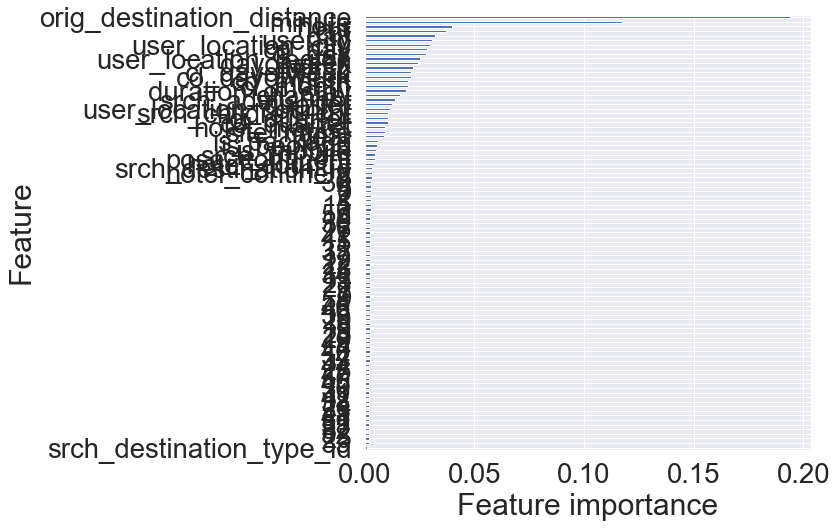

In [107]:
from pandas import Series

feature_importance = RFC.feature_importances_
Series_feat_imp = Series(feature_importance, index=train_new.drop('hotel_cluster', axis=1).columns)

plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### RFC 결과를 통해 알게 된 점
- 트레이닝 셋이 대해서는 학습이 잘 되었지만, 밸리데이션 셋에 대해서는 성능이 매우 저하된 것으로 보아 feature engineering을 충분히 잘하지 못했거나, overfitting이 되었다고 봄
- 샘플링 데이터로 먼저 시도하여 낮은 정확도를 얻은 후 전체 데이터 셋으로 학습 및 평가하였지만(sampling rate이 너무 낮은 문제일 수도 있다는 판단), 많은 성능 개선이 일어나지 않음
- feature importance를 뽑아보았을 때, orig_destination_distance, user_location등이 높은 importance를 보임 -> 

## 2-2. Support Vector Classification

In [ ]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc.fit(train_x, train_y)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

## 2-4. Popularity-based recommendation
- orig_destination_distance의 importance가 높다는 의미 : 호텔 선정에 거리가 중요 ->(filtering)-> 목적지별 인기있는 호텔이있을 것이다(가정)
- srch_destination_id에 대해 인기있는 hotel_cluster를 추천하는 방식 (booking & view weighting)